In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.copy_on_write = True

In [2]:
Inter_StateWarData = pd.read_csv("Inter-StateWarData_v4.0.csv")
Inter_StateWarData.columns

Index(['WarNum', 'WarName', 'WarType', 'ccode', 'StateName', 'Side',
       'StartMonth1', 'StartDay1', 'StartYear1', 'EndMonth1', 'EndDay1',
       'EndYear1', 'StartMonth2', 'StartDay2', 'StartYear2', 'EndMonth2',
       'EndDay2', 'EndYear2', 'TransFrom', 'WhereFought', 'Initiator',
       'Outcome', 'TransTo', 'BatDeath', 'Version'],
      dtype='object')

In [3]:
#import alliances data
df_raw= pd.read_csv("alliance_v4.1_by_directed.csv")

In [4]:
#remove shit we don't care about
dfpp=df_raw.drop(labels=list(['version4id','left_censor','right_censor','nonaggression','version','neutrality']),axis=1)
#filter out aliances where we don't know the end or start day's
#solution to use notna from stack overflow
df_clean1 = dfpp[dfpp['dyad_st_day'].notna()]
df=df_clean1[df_clean1['dyad_end_day'].notna()]
#convert to a date code
def datecode(year,month,day):
    datecode=year*365.25+month*30+day
    return datecode

starts=[]
ends=[]
#nessacary for iteration below
df.reset_index(drop=True,inplace=True)
for i in range(0,len(df)):
    #filter out non-defense non-entente alliances
    if not (df['defense'][i]==1.0 or df['entente'][i]==1):
        #print('')
        df.drop(i,axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)
#convert to datecodes
for i in range(0,len(df)):
    dcs=datecode(df['dyad_st_year'][i],df['dyad_st_month'][i],df['dyad_st_day'][i])
    starts.append(dcs)
    dce=datecode(df['dyad_end_year'][i],df['dyad_end_month'][i],df['dyad_end_day'][i])
    ends.append(dce)
df['datecode_st']=starts
df['datecode_end']=ends
#now that we have datecodes, drop the year,month,day labels
df.drop(axis=1,labels=['dyad_end_year','dyad_end_month','dyad_end_day','dyad_st_year','dyad_st_month','dyad_st_day'], inplace=True)
#we now have cleanish data
alliances=df

In [5]:
Inter_StateWarData.columns

Index(['WarNum', 'WarName', 'WarType', 'ccode', 'StateName', 'Side',
       'StartMonth1', 'StartDay1', 'StartYear1', 'EndMonth1', 'EndDay1',
       'EndYear1', 'StartMonth2', 'StartDay2', 'StartYear2', 'EndMonth2',
       'EndDay2', 'EndYear2', 'TransFrom', 'WhereFought', 'Initiator',
       'Outcome', 'TransTo', 'BatDeath', 'Version'],
      dtype='object')

In [6]:
#remove shit we don't care about
war_droped=Inter_StateWarData.drop(labels=list(['Version','StartMonth2', 'StartDay2','StartYear2']),axis=1)
#filter out aliances where we don't know the end or start day's
#solution to use notna from stack overflow
isw_data_w_s_dates = war_droped[war_droped['StartDay1'].notna()]
isw_data_w_e_dates = isw_data_w_s_dates[isw_data_w_s_dates['EndDay2'].notna()]
isw_partial  = isw_data_w_e_dates
starts=[]
ends=[]
#nessacary for iteration below
isw_partial.reset_index(drop=True,inplace=True)
#convert to datecodes
for i in range(0,len(isw_partial)):
    dcs=datecode(isw_partial['StartYear1'][i],isw_partial['StartMonth1'][i],isw_partial['StartDay1'][i])
    starts.append(dcs)
    if isw_partial['EndDay2'][i]<0:  #means we don't have a battle inturruption
        dce=datecode(isw_partial['EndYear1'][i],isw_partial['EndMonth1'][i],isw_partial['EndDay1'][i])
    else:
        dce=datecode(isw_partial['EndYear2'][i],isw_partial['EndMonth2'][i],isw_partial['EndDay2'][i])
    ends.append(dce)
isw_partial['datecode_st']=starts
isw_partial['datecode_end']=ends
#now that we have datecodes, drop the year,month,day labels
isw_partial.drop(axis=1,labels=['StartMonth1', 'StartDay1', 'StartYear1','EndMonth2','EndDay2', 'EndYear2','EndMonth1', 'EndDay1','EndYear1'], inplace=True)
#we now have cleanish data
isw_data=isw_partial

In [7]:
isw_data.head()

,WarNum,WarName,WarType,ccode,StateName,Side,TransFrom,WhereFought,Initiator,Outcome,TransTo,BatDeath,datecode_st,datecode_end
0,1,Franco-Spanish War,1,230,Spain,2,503,2,2,2,-8,600,665977.75,666193.75
1,1,Franco-Spanish War,1,220,France,1,503,2,1,1,-8,400,665977.75,666193.75
2,4,First Russo-Turkish,1,640,Ottoman Empire,2,506,11,2,2,-8,80000,667823.00,668326.25
3,4,First Russo-Turkish,1,365,Russia,1,506,11,1,1,-8,50000,667823.00,668326.25
4,7,Mexican-American,1,70,Mexico,2,-8,1,2,2,-8,6000,674396.50,674900.75


In [8]:
#create a graph of our allliances, for a given point in time by first filtering for those aliances wich ended before our start time,
# and then those with started after our end time
# we consider defense pacts and entente's as alliances, and ignore all other forms alliance forms, presuming enemies.

#now we should have a graph of alliances for some date code 
#graph this to check

In [9]:
#now for a given datecode, we construct a graph with all alliances active at that time:
#first we filter for only alliances that are within our datecode
def date_filter(dataframe,datecode):
    df=dataframe.reset_index(drop=True,inplace=False)
    for i in range(0,len(df)):
    #filter out alliances that aren't active, ie not dc_st < datecode< dcend
        if not (df['datecode_st'][i]<= datecode<=df['datecode_end'][i]):
            df.drop(i,axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    return df
#then we use the alliances to construct a graph (with only the alliances that we know)
def graph_constructor(dataframe,datecode):
    df=date_filter(dataframe=dataframe,datecode=datecode)
    edges_df = df.drop(labels=['state_name1','state_name2','defense','entente','datecode_end','datecode_st'],axis=1)
    #this feels stupid, but is probably the easiest way to do this
    edges=[]
    for i in range(0,len(edges_df)):#we use country codes for our verticies, to save memory, 
        #and append the start and end date of each alliance as a attributte of it
        edge=(df['ccode1'][i],df['ccode2'][i],{'start':df['datecode_st'][i],'end':df['datecode_end'][i]})
        edges.append(edge)
    alliances=nx.Graph(edges)
    return alliances

G= graph_constructor(df,665325.0)
#we can look up names later using the function defined below
def find_country_name(country_id, dataframe):
    name = df.where(df['ccode1']==country_id)['state_name1'].dropna().reset_index(drop=True)[0]
    return name
def append_state_names(graph,df):
    labels={}
    for node in graph.nodes:
        name=find_country_name(node,df)
        graph.nodes[node]['name']=name
        labels[node]=name
    return graph,labels
#G,labels=append_state_names(G,df)
#nx.draw_kamada_kawai(G,with_labels=True)
def draw_graph(graph,df):
    graph,names=append_state_names(graph,df)
    nx.draw_kamada_kawai(graph,labels=names)
    plt.show()
    return None

In [10]:
#animation for time codes
start=665325.0
stop=698067.75
times_step=np.arange(start=start,stop=stop,step=100)
times_lin=np.linspace(start=start,stop=stop,num=60)
#for time in times_lin:
#    G= graph_constructor(df,time)
#    G,names=append_state_names(G,df)
#    nx.draw_kamada_kawai(G,labels=names)
#    plt.show()

In [11]:
#usefull functions
#use the function below to map the probabilities of being in a class to the class itself, with a harsh cut-off of 0.5
def binarize(prob):#from hw 03
    if prob<0.5:
        return 0
    elif prob==0.5:
        rand =  generator.integers()%2
        return rand
    else:
        return 1

def dedupe_edges(edge_list):
    edge_graph = nx.Graph(edge_list)
    edges=[e for e in G.edges]
    return edges 
        

In [12]:
#now we can perform stability analysis, we/I (kyle) use the following metrics:
# for each neighbor (ally):
#how many of our neighbors (so the neighbors of neighbors) are enemies with each other (the original neigbors), and how many are allies, how many allies do we have
#ie each vertex(country) has a repulsive force for allying with another country (the numbere of it's current allies that are enemies with said country)
#and a attractive force (number of allies already allied with said country)
#we define functions for returning said forces below

def forces(graph, source_vertex, attracting_vertex):
    allies = graph.neighbors(source_vertex)
    attraction=0
    repulsion=0
    for ally in allies:
        if attracting_vertex in graph.neighbors(ally):
            attraction+=1
        else:
            repulsion+=1
    return attraction, repulsion,len(allies)
#recusive version of above for our k-neighbor's
def k_forces(graph,source_verticies,sink_vertex,k=1):
    allies = graph.neighbors(source_verticies)
    if k<=0:
        for ally in allies:
            if attracting_vertex in graph.neighbors(ally):
                k_attraction+=1
            else:
                k_repulsion+=1
        return k_attraction,k_repulsion,len(allies)
    else:
        k-=1
        k_forces(graph,allies,sink_vertex,k)
#clique analysis:
#WARNING THIS IS NP-COMPLETE AND THEREFORE SLOWS WITH SCALE EXTREMELY FAST
#have we formed a stable clique?, does is the graph either 2 complete subgraphs or a complete graph?

#we don't use clique analysis here yet, could be fed into ml algorithm but would be very slow
#def k_cliques(graph):

def is_complete_graph(G): #from google ai response/overview (nov  18 2024,16:03) to "networkx check if graph is complete"
    """
    Checks if a given graph is complete.

    Args:
        G (networkx.Graph): The graph to check.

    Returns:
        bool: True if the graph is complete, False otherwise.
    """

    n = G.number_of_nodes()
    edges=G.number_of_edges()
    return edges == n * (n - 1) // 2 
    #formula for number of edges of a complete graph, we can use since 
    #networkx doesn't allow duuplicate edges in a default graph, and edges in a complete graph is n*(n-1)//2 

def component_analysis(graph):
    """
    Input's: graph
    we find all components of the graph, check if they are complete,
    since by a mathematical theorem we know that the only stable arrangements are 
    2 distinct complete graphs, or 1 complete graph
    we check for the above scenarios, and output if the graph is stable (to continue our simulation)
    or unstable. We also output which case it is in, if stable.
    we also output the number of components and complete components for potential use elsewhere 
    and a war "probability" which is essentially a binary yes no of whether or not we are made of only complete components
    this could of course be modified to be much more complex, but we keep it simple for now
    outputs: number_connected_components, number_of_complete_components, stable, war,two_distinct_sg
    """
    components = nx.connected_components(graph)
    number_connected_components=nx.number_connected_components(graph)
    number_of_complete_components=0
    complete_com_sizes=[]
    stable=False
    war=0
    two_distinct_sg=False
    components_subgraph_list = [graph.subgraph(c).copy() for c in components] # modified from networkx documentation[https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html], converts our list of component generators into a list of component subgraphs  
    for subgraph in components_subgraph_list:
        if is_complete_graph(subgraph):
            number_of_complete_components+=1
            complete_com_sizes.append(len(subgraph.nodes()))
        else:
            continue
    if number_connected_components==number_of_complete_components:
        if number_of_complete_components==1:
            print(f'everyone is friends, peace is likely to persist for a while')
            stable=True
            war=0
        if number_of_complete_components==2:
            stable=True
            two_distinct_sg=True
            war=1
            print(f'war is inevitable, we have a stable graph, with 2 complete components of sizes {complete_com_sizes[0]}, and {complete_com_sizes[1]} ')
        else:
            stable=False
            war=0.3#? clearly war is likely, but it probably isn't inevitable
           # print(f'graph is unstable, with  {number_connected_components} seperate alliance gropus, war is probably inevitable')
    else:
        stable=False
        print(f'graph is unstable, with {number_connected_components} groups, allilances are likely to shift before war can break out')
        war=0
    return number_connected_components,number_of_complete_components,stable,war,two_distinct_sg

In [13]:
def force_favor(graph,time,source_country,sink_country):
    """
    Inputs: graph, timecode, source and sink countries to check
    ouputs: stability of edge: 1.0 strongly favors alliance, -1.0 strongly favors enemies
    """
    attr,repul,tsize= forces(graph,source_vertex=source_country,attracting_vertex=sink_country)
    tsize=attr+repul
    #attr_ratio= attr/
    #repul_ratio= repul/
    net_force= (attr-repul)
    scaled_force  =  (attr-repul)/tsize
    #normalized_force =  scaled_force*.5 +.5#need to correct currently returns stability of graph edge, not likelyhood of f>
    return scaled_force

def force_flip(graph,time,source_country,sink_country,pred_params):
    """
    Inputs: graph, timecode, source and sink countries to check
    ouputs: flip probability, 1.0 is high flip chance, 0.0 is no flip chance
    """
    scaled_force=force_favor(graph,time,source_country,sink_country)
    normalized_force =  scaled_force*.5 +.5
    if graph.has_edge((source_country,sink_country)):
        if scaled_force>0:#alliance favored and we already have one, low flip likelyhood
            return 1-normalized_force #normalized force is >0.5 in this case,  so low flip likelyhood is 1-normalized force
        elif  scaled_force<0:#no alliance/enemies favored, but we are currently allies,  high flip likelyhood
            return 1- normalized_force#normalized force is <0.5 in this case,  so high flip likelyhood is 1-normalized force
        else: #no side favored, assume random chance of flipping (note this is wrong, we should probably default to a low l>
            return 0.5
    else: # we don't already have an edge, meaning we are enemies between source and sink
        if scaled_force>0: #alliance formation favored
            return normalized_force
        elif  scaled_force<0: #favor staying as enemies
            return normalized_force
        else: #neither side favored
            return 0.5

In [14]:
# to be done by other group members:


"""
finish these cells

"""

#
def train_models():
    #seperate call to train any models passed in pred_params to likelyhood of relationship flipping function
    return models

def  generate_flip_dataset(start_tc,end_tc):
    #takes in a set of times, and returns a timecode of when edges flipped for training
    
    return data

def likelyhood_of_relationship_flipping(graph,time,source_country,sink_country,pred_params):
    """ 
    Input: graph, timecode, the source and sink countries 
    (order doesn't/shouldn't actually matter) and any aditional prediction parameters we need
    Output: a 0-1 probability that the relationshib between 2 countries will flip
    how/methods: logistic regression? PCA? """
    return flip_probablity

In [15]:
def flipped_at_list_graph(graph,flip_relations_list):
    #flips the realations of a graph at the listed "edges"
    #first we deduplicate identical edges
    flip_relations_list=dedupe_edges(flip_relations_list)
    #now we can flip
    for i in range(0,len(flip_relations_list)):
        edge=flip_relations_list[i]
        if graph.has_edge(edge[0],edge[1]):
            graph.remove_edge(edge[0],edge[1])
        else:
            graph.add_edge(edge[0],edge[1])
    return graph

    
#we predict alliance changes for each vertex at each timestep:
def Simulate_at_graph(graph, time, pred_params):
    flip_relations_list=[]
    #number_connected_components,number_of_complete_components,stable,war,two_distinct_sg = component_analysis(graph)# check if war is inevitable yet
    #check each possible edge 
    #SLOW
    for source_country in graph.nodes():
        graph_no_source=graph.copy().remove_node(source_country)
        if not type(graph_no_source) == type(None):#means we have more than 1 node in our graph
            for sink_country in graph_no_source.nodes():
                #check if we are likely to change relations
                flip_chance = binarize(force_flip(graph,time,source_country,sink_country,pred_params))
                if flip_chance == 1:
                    flip_relations_list.append((source_country,sink_country))
                else:
                    continue
        else:
            flip_relations_list=[] # can't flip only one vertex
    # now create a new graph with our flipped relations, and return it
    return flipped_at_list_graph(graph,flip_relations_list)

#now we iterate over the known (time, and graphs) and identify when we may have weakly connected large cliques, or complete subgraphs

In [16]:
def simulate_from_to(graph,start_time,end_time,time_steps=7,pred_params=None):
    """
    Inputs: graph, start_time (days AD), end_time (days AD), time_steps (in days), prediction parameters
    Outputs: predicted war date, and either graph animation in notebook, or saved mp4, 
    with prediction labels
    
    this function is our simulation harness, we:
    first:
    check if we are in a stable state, and stop if we are
    check for war inevitability in the above step
    output results if we are stable, which should occur anyways
    then:
    run our simulation on our current graph, 
    commit the proposed changes,
    and advance to the next timestep, until we either:
    reach stability, in which case we output if war is likely, 
    we could skip ahead (in the real data) to when we are unstable, but we don't as of yet, 
    that is for a seperate function.
    or reach our end time of the simulation
    """
    G=graph
    graphs_over_time=[]
    war=False
    times=np.arange(start=start_time,stop=end_time,step=time_steps)
    for time in times:
        number_connected_components,number_of_complete_components,stable,war,two_distinct_sg = component_analysis(G)# check if war is inevitable yet
        if stable:
            graphs_over_time.append(G)
            if two_distinct_sg:
                war=True
                return graphs_over_time,time,war #time of predicted war inevitability
        else:
            graphs_over_time.append(G)
            G=Simulate_at_graph(G,time,pred_params)
    return graphs_over_time,end_time,war


def war_predictions(base_alliance_dataframe,starting_graph,start_time,end_time,time_steps=7,pred_params=None):
    """
    simulates graph, same as above
    fast forwards to when we aren't stable to get more war predictions if we are
    stores predicted times of war in a list, that get's returned
    """
    war_times = []
    graph_blocks=[]
    #we tile simulations together when they end
    #how to do this
    current_last_time=start_time
    prev_last_time=0
    graph=starting_graph
    while current_last_time <= end_time:
        #consider adding a fast-forward function if we cant move forward
        graphs_over_time_block, current_last_time, war = simulate_from_to(graph,current_last_time,end_time,time_steps,pred_params)
        #skip to next step if we get stuck
        if prev_last_time == current_last_time:
            print("stuck at:  ",current_last_time)
            current_last_time+= time_steps
            #esetting starting graph from dataframe, to known real alliances
            graph=graph_constructor(base_alliance_dataframe,current_last_time)
        graph_blocks.append(graphs_over_time_block)
        
        prev_last_time=current_last_time

        if war:
            #states=graphs_blocks[-1][-1].nodes()# most recent graph block, most recent graph (the one where war is probable)
            wg=graphs_over_time_block[-1]# most recent graph (the one where war is probable)
            states=wg.nodes()
            war_times.append((current_last_time,states))
            print("war at:  ",current_last_time, "resetting to data")
            #draw war graph as a sanity check
            draw_graph(wg,base_alliance_dataframe)
            #resetting starting graph from dataframe, to known real alliances
            graph=graph_constructor(base_alliance_dataframe,current_last_time)
    
    return war_times,graph_blocks

    
def gen_war_dataset_for_timecodes(df,start_dc,stop_dc):
    data=df.reset_index(drop=True,inplace=False)
    for i in range(0,len(data)):
    #filter out war's that aren't active within our timerange,
    #ie war_end_date <start or  war_start_date > stop
        if (data['datecode_st'][i]>stop_dc) or (data['datecode_end'][i]<start_dc):
            data.drop(i,axis=0,inplace=True)
    data.reset_index(drop=True,inplace=True)
    return data

def find_matching_war(countries, date, war_data_frame,window=30*6):
    """
    Input: country code id's as a iterable list of nodes; countries
    date: earliest datecode of war,
    window: size in day's of window to search through
    war_datwar_data_frame: dataframe with start and stop datecodes for actual war's, and
    """
    search_data_frame=gen_war_dataset_for_timecodes(war_data_frame,start_dc=date, stop_dc=date+window)
    for i in range(0,len(search_data_frame)): #loop over all the real war's that occured for our search time period
        for country in countries: #loop over our predicted countries at war
            if search_data_frame['ccode'][i]==country: #if any of them are at war, which matches the actual dataframe country code war,
                #assume we have found our war
                return True
    return False

def true_pred_accuracy(war_pred,true_war_df,day_window=30*6): #six month window by default, based off ww1 outbreak time
    #when we predict a war, how often does one actually break out between our component alliances within a given time window
    correct_num_predictions=0
    false_num_predictions=0
    if not len(war_pred)==0:
        for predicted_war in war_pred:
            war_earliest_date=predicted_war[0]
            countries=predicted_war[1]
            matching_war_found=find_matching_war(countries,war_earliest_date,true_war_df,window=day_window)
            if matching_war_found:
                correct_num_predictions+=1
            else:
                false_num_predictions+=1
    positive_accurac= correct_num_predictions/(correct_num_predictions+false_num_predictions)
    return positive_accurac

graph is unstable, with 1 groups, allilances are likely to shift before war can break out
war at:   698067.75 resetting to data


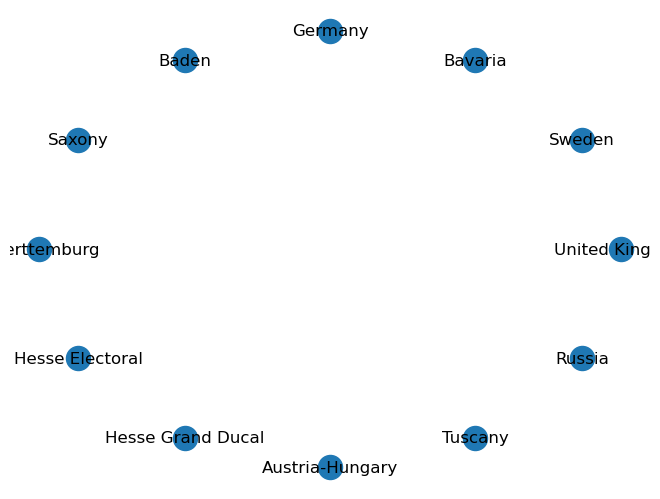

stuck at:   698067.75
0.0


In [17]:
#procedural run our model time:
start_time=665325.0
end_time=698067.75
alliances=df
real_wars=isw_data
G= graph_constructor(df,start_time)
pred_war_times, graphs_over_time = war_predictions(base_alliance_dataframe=alliances,starting_graph=G,start_time=start_time,end_time=end_time,time_steps=7,pred_params=None)
positive_rate=(true_pred_accuracy(pred_war_times,real_wars,day_window=30*12))
print(positive_rate)